# Проект: Исследование надежности заемщиков клиентов банка:

##### Содержание <a class="anchor" id="содержание"></a>

* [Описание проекта](#Описание-проекта)
* [Часть 1. Изучение и предобработка данных](#p-1)
** [1.1 Загрузка и изучение данных](#p-1.1)
** [1.2 Предобработка данных](#p-1.2)
* [Часть 2. Исследовательский анализ данных (EDA)](#p-2)
** [2.1 Проверка зависимости между уровнем дохода и возвратом кредита в срок](#p-2.1)
** [2.2 Проверка зависимости между количеством детей и возвратом кредита в срок](#p-2.2)
** [2.3 Проверка зависимости между семейным положением и возвратом кредита в срок](#p-2.3)
** [2.4 Проверка зависимости между целями кредита и его возвратом](#p-2.4)
** [2.5 Ответы на вопросы к заданию](#p-2.5)
* [Часть 3. Выводы](#p-3)

## [Описание проекта](#содержание)<a class="anchor" id="Описание-проекта"></a>

#### Заказчик

Заказчик — кредитный отдел банка.

#### Задача

Определить наличие влияния семейного положения и количества детей клиента на факт погашения кредита в срок для построения модели кредитного скоринга.

#### Данные

Входные данные от банка — статистика о платёжеспособности клиентов, представленная в файле data.csv.

    Колонки:
    - children — количество детей в семье
    - days_employed — общий трудовой стаж в днях
    - dob_years — возраст клиента в годах
    - education — уровень образования клиента
    - education_id — идентификатор уровня образования
    - family_status — семейное положение
    - family_status_id — идентификатор семейного положения
    - gender — пол клиента
    - income_type — тип занятости
    - debt — имел ли задолженность по возврату кредитов
    - total_income — ежемесячный доход
    - purpose — цель получения кредита


## [Часть 1. Изучение и предобработка данных](#содержание)<a class="anchor" id="p-1"></a>

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [163]:
import warnings
warnings.filterwarnings("ignore")

In [164]:
# Зададим стиль графиков
sns.set_theme(context='notebook',
           style='darkgrid',
           palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [165]:
# Снимем ограничение на вывод строк и столбцов
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# Выставим ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

##### [Часть 1.1 Загрузка и изучение данных](#содержание)<a class="anchor" id="p-1.1"></a>

In [166]:
try:
    df = pd.read_csv('/home/danil/DA_projects/01_project/data.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [168]:
# Функция для определения уникальных значений, дубликатов и пропусков
def describe_cols(df):
    
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [sorted(df[col].unique()),
                       df[col].nunique(),
                       df[col].duplicated().sum(),                      
                       df[col].isna().sum(),
                       (df[col].isna().sum()/len(df))*100,
                       df[col].dtype]
        
    return values.transpose().sort_values(by=1, ascending=True).rename(
        {0: 'Значения',
         1: 'Кол-во уник. значений',
         2: 'Дубликаты в столбце',
         3: 'Пропуски',
         4: 'Процент пропусков от датасета',
         5: 'Тип данных'}, axis=1)

In [169]:
describe_cols(df)

,Значения,Кол-во уник. значений,Дубликаты в столбце,Пропуски,Процент пропусков от датасета,Тип данных
debt,"[0, 1]",2,21523,0,0.00,int64
gender,"[F, M, XNA]",3,21522,0,0.00,object
education_id,"[0, 1, 2, 3, 4]",5,21520,0,0.00,int64
family_status,"[Не женат / не замужем, в разводе, вдовец / вдова, гражданский брак, женат / замужем]",5,21520,0,0.00,object
family_status_id,"[0, 1, 2, 3, 4]",5,21520,0,0.00,int64
children,"[-1, 0, 1, 2, 3, 4, 5, 20]",8,21517,0,0.00,int64
income_type,"[безработный, в декрете, госслужащий, компаньон, пенсионер, предприниматель, сотрудник, студент]",8,21517,0,0.00,object
education,"[ВЫСШЕЕ, Высшее, НАЧАЛЬНОЕ, НЕОКОНЧЕННОЕ ВЫСШЕЕ, Начальное, Неоконченное высшее, СРЕДНЕЕ, Среднее, УЧЕНАЯ СТЕПЕНЬ, У...",15,21510,0,0.00,object
purpose,"[автомобили, автомобиль, высшее образование, дополнительное образование, жилье, заняться высшим образованием, занять...",38,21487,0,0.00,object
dob_years,"[0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, ...",58,21467,0,0.00,int64


Столбцы debt, gender, education_id, education, family_status, family_status_id, income_type содержат категориальные данные.
Столбцы children, dob_years, days_employed, total_income содержат количественные данные.

Столбцы days_employed и total_income содержат 10.1% пропусков.
Столбцы education, children, days_employed содержат аномалии.

##### [Часть 1.2 Предобработка данных](#содержание)<a class="anchor" id="p-1.2"></a>

In [170]:
# Приведем в столбце education данные в нижний регистр
df['education'] = df['education'].str.lower()

In [171]:
# Проверим наличие явных дубликатов
df.duplicated().sum()

71

Датасет не содержит столбцов, которые бы позволили точно идентифицировать конкретного клиента, при этом содержит 71 явный дубликат.

In [172]:
# Удалим явные дубликаты
df = df.drop_duplicates()

In [173]:
# Проверим количество аномалий в столбце children
df['children'].value_counts()

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [174]:
len(df.query('0 <= children <= 5')) / len(df)

0.9942668033933066

Количество аномальных записей в столбце составляет меньше 1 процента. Учитывая, что вообще отсутствует информация о клиентах с количеством детей от 6 до 20, можно предположить, что аномальные записи сформировались в результате ошибки при сборе данных. Удалять записи не требуется, при определении зависимости ненадежности клиентов от количества детей эти строки исключим.

In [175]:
# Приведем данные в столбце days_employed к положительным значениям
df['days_employed'] = df['days_employed'].abs()

In [176]:
# Проверим медианные значения стажа по категориям занятости
df.groupby('income_type')['days_employed'].agg(['median'])

,median
income_type,
безработный,"366,413.65"
в декрете,"3,296.76"
госслужащий,"2,689.37"
компаньон,"1,547.38"
пенсионер,"365,213.31"
предприниматель,520.85
сотрудник,"1,574.20"
студент,578.75


В двух категориях ("безработный", "пенсионер") данные стажа в днях аномально велики. С учетом того, что данный столбец не будет использоваться в исследовании, оставим данные в нём без изменений.

##### столбец total_income

Выясним тип пропусков в столбце total_income и  выберем дальнейшую стратегию обработки.

In [177]:
# Добавляем столбец omission с признаком пропуска
df['omission'] = df['total_income'].apply(lambda x: 1 if x >= 0 else 0)

In [178]:
# Проверяем меру центральной тенденции для клиентов с пропусками в столбце total_income и без пропусков
agg_func_stats = {'debt':[pd.Series.mode],
                  'gender':[pd.Series.mode],
                  'education':[pd.Series.mode],
                  'education_id':[pd.Series.mode],
                  'family_status':[pd.Series.mode],
                  'family_status_id':[pd.Series.mode],
                  'children':[pd.Series.mode],
                  'income_type':[pd.Series.mode],
                  'days_employed':'median',
                  'total_income':'median',
                  'dob_years':'median'}


(
    df.groupby(['omission'])
    .agg(agg_func_stats)
)

,debt,gender,education,education_id,family_status,family_status_id,children,income_type,days_employed,total_income,dob_years
,mode,mode,mode,mode,mode,mode,mode,mode,median,median,median
omission,,,,,,,,,,,
0,0,F,среднее,1,женат / замужем,0,0,сотрудник,NaN,NaN,43.00
1,0,F,среднее,1,женат / замужем,0,0,сотрудник,"2,194.22","145,017.94",42.00


Пропуски в столбце balance относятся к типу MNAR (механизм формирования пропусков, при котором данные отсутствуют в зависимости от неизвестных факторов). Причина, по которой они образовались, достоверно неизвестна, но при отсутствии данных в столбце total_income, у таких клиентов также отсутствуют данные о стаже в днях (days_employed), что может быть признаком закономерности. Заполнение пропусков синтетическими данными (медианным, средним и т.д.) может оказаться некорректным, удаление строк приведет к потере данных, поэтому строки с пропусками оставим.

In [179]:
# Подсчитаем значения в столбце gender
df['gender'].value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

In [180]:
# Оставим строки только с значениями "M" и "F"
df = df.query('gender == "M" | gender == "F"')

##### Категоризация клиентов по уровню доходов

На основании диапазонов, определенных кредитным отделом банка-заказчика, создадим в датафрейме data столбец total_income_category с категориями:

    0–30000 — 'E';
    30001–50000 — 'D';
    50001–200000 — 'C';
    200001–1000000 — 'B';
    1000001 и выше — 'A'.

In [181]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [182]:
df['total_income_category'] = df['total_income'].apply(categorize_income)

##### Категоризация клиентов по целям получения кредита

На основании данных из столбца `purpose` сформируем новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.


In [183]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [184]:
df['purpose_category'] = df['purpose'].apply(categorize_purpose)

In [185]:
df.head(2)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,omission,total_income_category,purpose_category
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья,1,B,операции с недвижимостью
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля,1,C,операции с автомобилем


## [Часть 2. Исследовательский анализ данных (EDA)](#содержание)<a class="anchor" id="p-2"></a>

##### [Часть 2.1 Проверка зависимости между уровнем дохода и возвратом кредита в срок](#содержание)<a class="anchor" id="p-2.1"></a>

Проанализируем распределение доходов у надежных и ненадежных клиентов банка, отфильтровав выбросы по 99 процентилю.

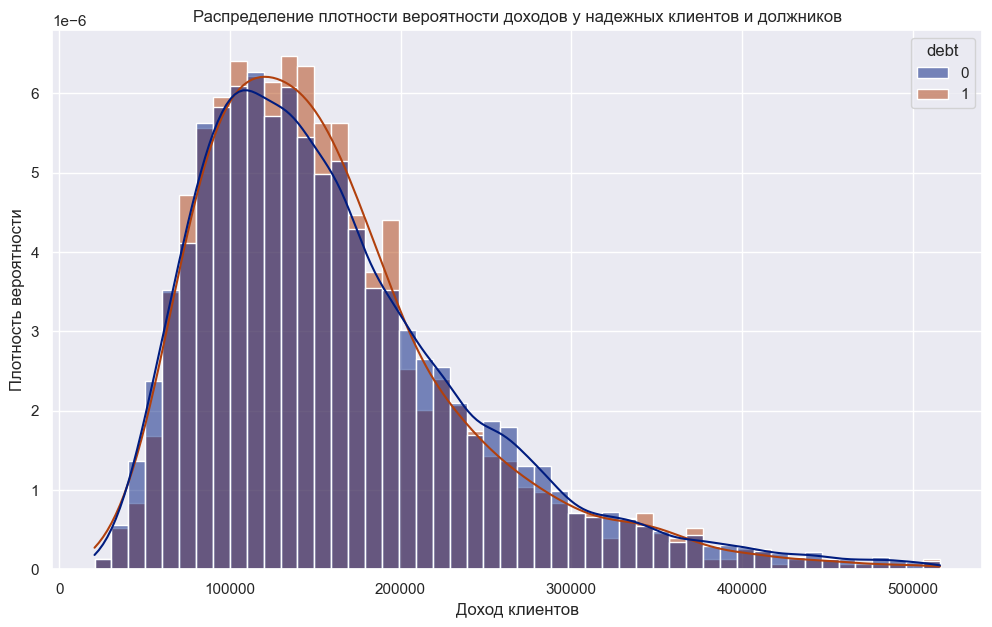

In [186]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.histplot(data=df[df['total_income']\
                     <= np.percentile(df[df['total_income'] >= 0]['total_income'], 99)],
             x=df[df['total_income']\
                  <= np.percentile(df[df['total_income'] >= 0]['total_income'], 99)]['total_income'],
             hue=df['debt'], bins=50, kde=True, stat="density", common_norm=False)
ax.set_xlabel('Доход клиентов')
ax.set_ylabel('Плотность вероятности')
ax.set_title('Распределение плотности вероятности доходов у надежных клиентов и должников')

fig.show()

In [187]:
# Подсчитаем статистические параметры для лояльной и отточных групп без выбросов
pd.concat([df[(np.percentile(df[df['total_income'] >= 0]['total_income'], 1) <= df['total_income']) &\
              (df['total_income'] <= np.percentile(df[df['total_income'] >= 0]['total_income'], 95)) &\
              (df['debt'] == 0)][['total_income']].rename(columns={'total_income':'loyal_income'}),
           df[(np.percentile(df[df['total_income'] >= 0]['total_income'], 1) <= df['total_income']) &\
              (df['total_income'] <= np.percentile(df[df['total_income'] >= 0]['total_income'], 95)) &\
              (df['debt'] == 1)][['total_income']].rename(columns={'total_income':'disloyal_income'})],
          axis=1).describe()

,loyal_income,disloyal_income
count,"16,695.00","1,493.00"
mean,"153,087.08","150,906.09"
std,"65,613.08","62,582.78"
min,"43,715.00","44,577.78"
25%,"102,109.54","103,794.58"
50%,"141,908.13","141,155.94"
75%,"194,255.02","187,179.22"
max,"340,484.57","340,546.27"


Распределение плотности вероятности и статистические параметры величины дохода у надежных и ненадежных клиентов сопоставимы.

Построим диаграмму долей должников по категориям дохода, определенных банком.

In [188]:
(
    df.query('debt == 0')
    .groupby(['total_income_category'])
    .agg({'debt':'count'})
)[['debt']].rename(columns={'debt':'loyal_clients'}).join((
    df.query('debt == 1')
    .groupby(['total_income_category'])
    .agg({'debt':'count'})
)[['debt']].rename(columns={'debt':'disloyal_clients'}), how='left')

,loyal_clients,disloyal_clients
total_income_category,,
A,23,2
B,4684,356
C,12723,1190
D,329,21
E,20,2


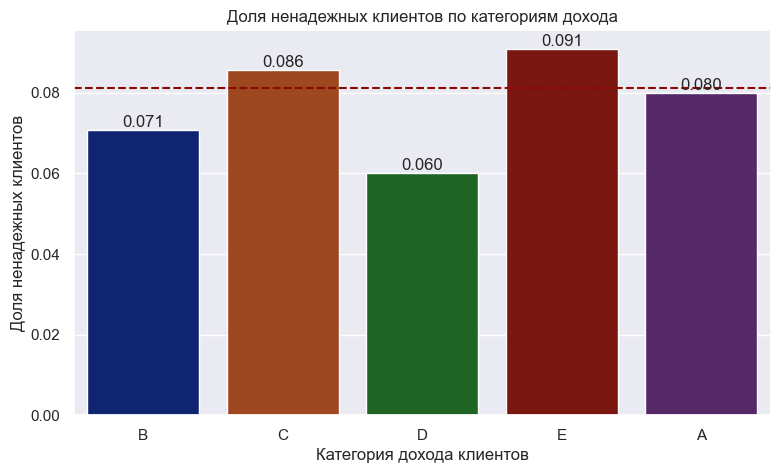

In [189]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.barplot(data=df,
             x=df['total_income_category'], y=df['debt'], ci=None)
ax.axhline(y=(len(df[df['debt'] == 1]) / len(df)),
                   color="r",
                   clip_on=False,
                   linestyle ='--')
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xlabel('Категория дохода клиентов')
ax.set_ylabel('Доля ненадежных клиентов')
ax.set_title('Доля ненадежных клиентов по категориям дохода')

fig.show()

Самой рисковой категорией, клиенты которой часто допускают задержки по выплатам, оказалась средняя по доходам категория "С" (8,6% должников). В категориях "B" и "D" должников меньше, их доли 7,1% и 6,0% соответственно. Также высокий процент неисправных клиентов в категориях с самым низким и самым высоким уровнем доходов "A" и "E" (8% и 9,1% должников), но необходимо учитывать тот факт, что количество клиентов этих категорий очень мало и может оказаться недостоверным.

##### [Часть 2.2 Проверка зависимости между количеством детей и возвратом кредита в срок](#содержание)<a class="anchor" id="p-2.2"></a>

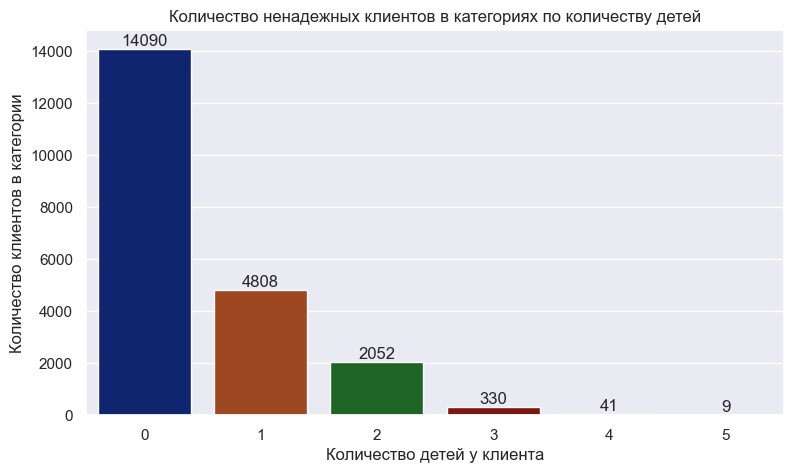

In [190]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.countplot(data=df.query('children != -1 & children != 20'),
             x=df.query('children != -1 & children != 20')['children'])
ax.bar_label(ax.containers[0], fmt='%.f')
ax.set_xlabel('Количество детей у клиента')
ax.set_ylabel('Количество клиентов в категории')
ax.set_title('Количество ненадежных клиентов в категориях по количеству детей')

fig.show()

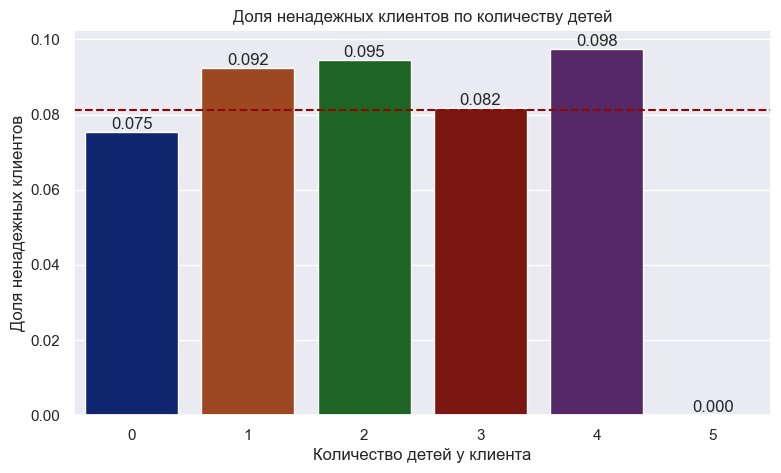

In [191]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.barplot(data=df.query('children != -1 & children != 20'),
             x=df.query('children != -1 & children != 20')['children'],
            y=df.query('children != -1 & children != 20')['debt'], ci=None)
ax.axhline(y=(len(df[df['debt'] == 1]) / len(df)),
                   color="r",
                   clip_on=False,
                   linestyle ='--')
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xlabel('Количество детей у клиента')
ax.set_ylabel('Доля ненадежных клиентов')
ax.set_title('Доля ненадежных клиентов по количеству детей')

fig.show()

Клиенты без детей реже всего допускают задержки по выплатам, чем клиенты с детьми. Количество клиентов с тремя и более детьми очень невелико и данных по ним недостаточно.

##### [Часть 2.3 Проверка зависимости между семейным положением и возвратом кредита в срок](#содержание)<a class="anchor" id="p-2.3"></a>

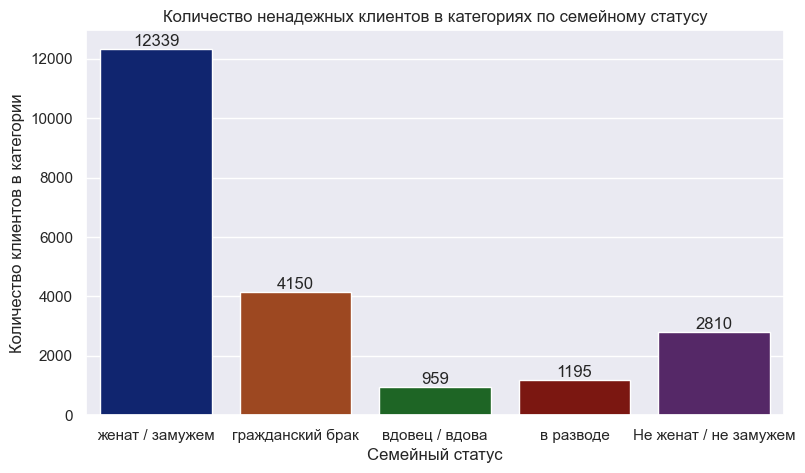

In [192]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.countplot(data=df,
             x=df['family_status'])
ax.bar_label(ax.containers[0], fmt='%.f')
ax.set_xlabel('Семейный статус')
ax.set_ylabel('Количество клиентов в категории')
ax.set_title('Количество ненадежных клиентов в категориях по семейному статусу')

fig.show()

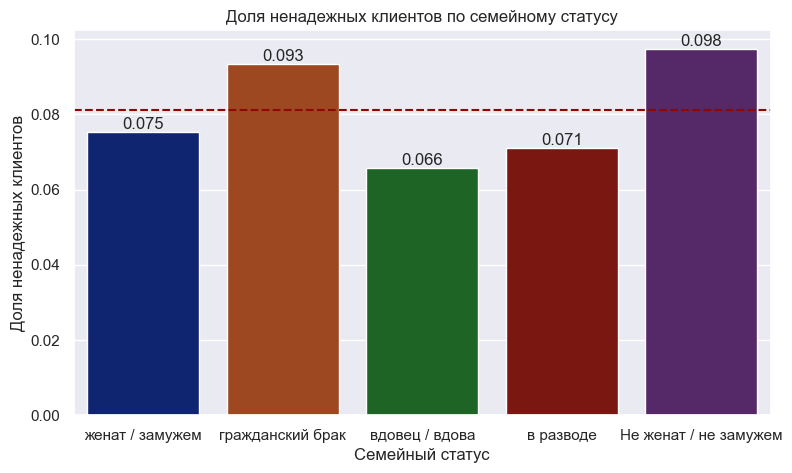

In [193]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.barplot(data=df,
             x=df['family_status'],
            y=df['debt'], ci=None)
ax.axhline(y=(len(df[df['debt'] == 1]) / len(df)),
                   color="r",
                   clip_on=False,
                   linestyle ='--')
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xlabel('Семейный статус')
ax.set_ylabel('Доля ненадежных клиентов')
ax.set_title('Доля ненадежных клиентов по семейному статусу')

fig.show()

Наиболее рисковые категории клиентов - неженатые/незамужние и находящиеся в гражданском браке клиенты. Доля ненадежных клиентов в других категориях меньше средней по датасету.

##### [Часть 2.4 Проверка зависимости между целями кредита и его возвратом](#содержание)<a class="anchor" id="p-2.4"></a>

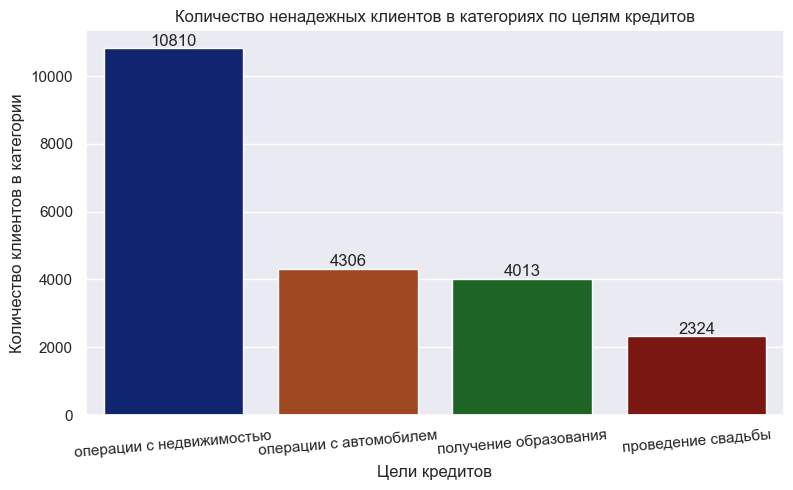

In [194]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.countplot(data=df,
             x=df['purpose_category'])
ax.bar_label(ax.containers[0], fmt='%.f')
ax.set_xlabel('Цели кредитов')
ax.set_ylabel('Количество клиентов в категории')
ax.set_title('Количество ненадежных клиентов в категориях по целям кредитов')
ax.tick_params(axis='x', rotation=5)

fig.show()

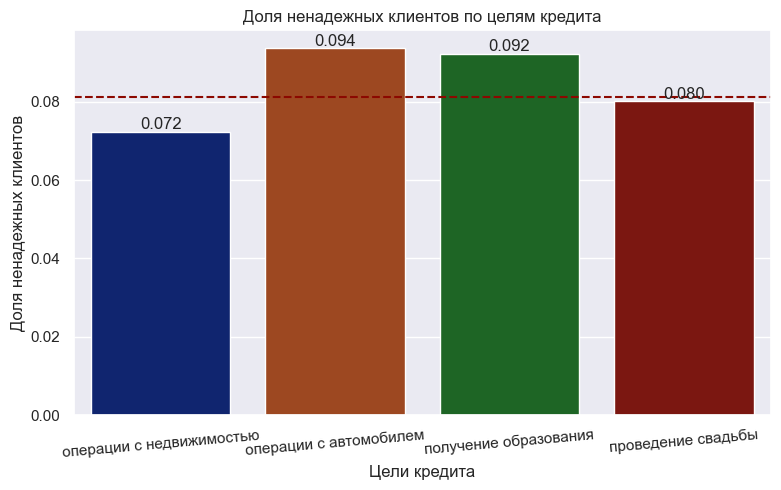

In [195]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.barplot(data=df,
             x=df['purpose_category'],
            y=df['debt'], ci=None)
ax.axhline(y=(len(df[df['debt'] == 1]) / len(df)),
                   color="r",
                   clip_on=False,
                   linestyle ='--')
ax.bar_label(ax.containers[0], fmt='%.3f')
ax.set_xlabel('Цели кредита')
ax.set_ylabel('Доля ненадежных клиентов')
ax.set_title('Доля ненадежных клиентов по целям кредита')
ax.tick_params(axis='x', rotation=5)

fig.show()

Наиболее надежны клиенты, цель которых операции с недвижимостью, наименее - операции с автомобилем или получение образования.

##### [Часть 2.5 Ответы на вопросы к заданию](#содержание)<a class="anchor" id="p-2.5"></a>

**Приведите возможные причины появления пропусков в исходных данных.**

Ответ: Причинами могут быть ошибки ввода данных, сокрытие информации или технические проблемы. Также можно предположить, что клиенты не смогли документально подтвердить информацию о стаже и доходе.

**Объясните, почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.**

Ответ: Медиана является альтернативой среднему арифметическому, т.к. игнорирует аномально высокие или аномально низкие значения исследуемых величин.



## [Часть 3. Выводы](#содержание)<a class="anchor" id="p-3"></a>

В результате исследования предоставленной базы данных сделаны следующие выводы:

1) Наиболее рисковыми группами клиентов являются клиенты с детьми (9,24% должников от общего числа клиентов), не имеющие штампа в паспорте (не женатые/не замужние 9,76% и находящиеся в гражданском браке 9,31% должников от общего числа клиентов), клиенты со средним доходом, соответствующим категории "С" по классификации банка (9,25% должников от общего числа клиентов), а также клиенты, целью кредита которых являются операции с автотранспортным средством или получение образования (9,34% и 9,25% должников от общего числа клиентов). 

2) Наиболее исправными являются клиенты без детей (7,54% должников от общего числа клиентов), разведенные и семейные (7,06% и 7,56% должников от общего числа клиентов), клиенты с доходом выше среднего, принадлежащие к категории "D" по банковской классификации (6,01% должников от общего числа клиентов), а также клиенты с кредитами для операций с недвижимостью (7,25% должников от общего числа клиентов). 

3) Следует учесть, что для более точного исследования процентных долей должников по категориям количества детей и ежемесячных доходов в их крайних группах, необходимо большее количество данных. 

4) Для более гибкого анализа категорий клиентов, с целью определения доли должников, возможно потребуется провести исследование совокупности категорий наличия детей и дохода, образования клиентов, дохода и возраста клиентов и т.д.
